In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from textblob import TextBlob

In [32]:
IS_SAMPLE_ANALYSIS = False
TARGET = 'tesla'
if IS_SAMPLE_ANALYSIS:
    TARGET += '_sample'
FIGURE_SIZE = (16,9)

In [33]:
cols = ['text','timestamp','user','tweet_source','tweet_id','user_location','source_device']
tweets = pd.read_csv('../data/' + TARGET + '.csv', names=cols)

In [34]:
tweets.tail()

,text,timestamp,user,tweet_source,tweet_id,user_location,source_device
77780,@thirdrowtesla God I'm so sick of this. Every ...,1.584861e+09,AerialEng,1241528563398049793,1241623788359315458,NaN,Twitter for iPhone
77781,Yo who is down to key a tesla tonight,1.584861e+09,Ex__lion_tamer,1241624132187344898,1241624132187344898,NaN,Twitter Web App
77782,@d4t4wr4ngl3r @thirdrowtesla That doesn't chan...,1.584861e+09,AerialEng,1241538576686465025,1241624417924341760,NaN,Twitter for iPhone
77783,Addressing #COVID19: \nElon Musk + Tesla + Med...,1.584861e+09,MDT_RMS_EMEA,1241624697139351552,1241624697139351552,Switzerland,Khoros Marketing
77784,"@sacramentotesla @yashar ""all he said was that...",1.584861e+09,statsboye,1241624808774709249,1241624808774709249,Washington State,Twitter Web App


## Tweet distribution over time

In [35]:
dates = pd.DataFrame(tweets['timestamp']/1000)

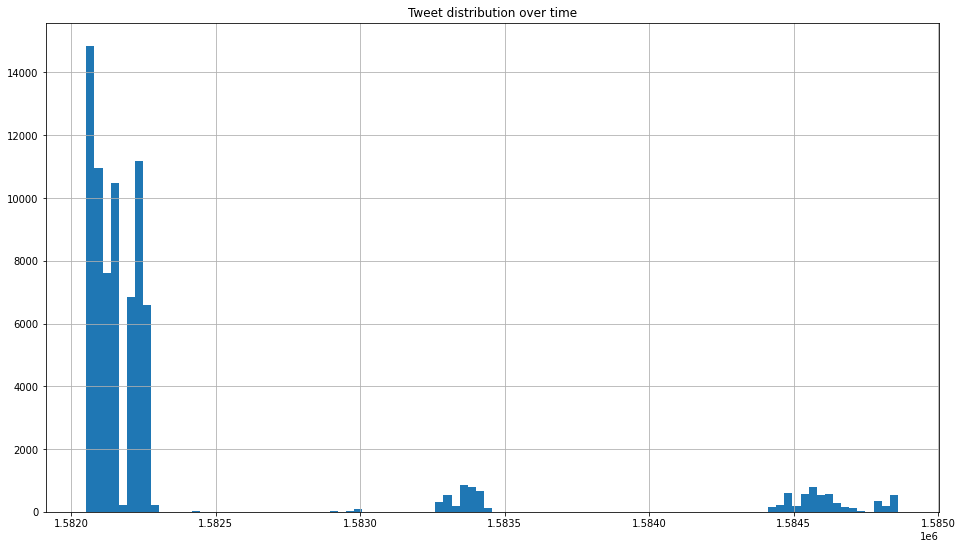

In [36]:
dates.hist(bins=100, figsize=FIGURE_SIZE)
plt.title('Tweet distribution over time')
plt.show()

## Cleaning
- Remove
    - All urls
    - '#' form infront of hashtags
    - mentions
    - emojis
    - Non ASCII chanracters

In [37]:
import re
import preprocessor as p

# Don't remove hastags
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.NUMBER, p.OPT.SMILEY, p.OPT.RESERVED, p.OPT.MENTION)

NOT_BASIC_LATIN_PATTERN = re.compile(u'[^\u0000-\u007F]')
PUNCTUATIONS_PATTERN = re.compile(r'[\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]')
MULTIPLE_SPACES_PATTERN = re.compile(r' +')

def clean_text(text):
    text = text.lower()
    text = p.clean(text) # Clean using tweet-preprocessor except hashtags
    text = NOT_BASIC_LATIN_PATTERN.sub(' ', text) # Remove everything except basic latin
    text = re.sub(r'&amp;', 'and', text)
    text = PUNCTUATIONS_PATTERN.sub(' ', text) # Remove all punctuations
    text = MULTIPLE_SPACES_PATTERN.sub(' ', text) # Remove multiple consequent spaces
    return text.strip()

In [38]:
%%time
tweets['clean_text'] = tweets['text'].apply(lambda x: clean_text(x))
tweets[['text','clean_text']].head()

CPU times: user 8.48 s, sys: 109 ms, total: 8.59 s
Wall time: 8.9 s


,text,clean_text
0,"Tesla entwickelte das Teil, das neben Fahrassi...","tesla entwickelte das teil, das neben fahrassi..."
1,Highlight: “We’re seeing Tesla up another 6% t...,highlight we re seeing tesla up another today ...
2,Tesla decidió descartar Cataluña para su nueva...,tesla decidi descartar catalu a para su nueva ...
3,Elon Musk calls Bill Gates ‘underwhelming’ htt...,elon musk calls bill gates underwhelming
4,@ATNX143 @slicctor @CNN And accept the fact th...,and accept the fact that competitors like pors...


## Analysis of words used in cleaned tweets

### Most used words

In [39]:
import nltk
from nltk.text import Text
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

tokenizer = TweetTokenizer()

all_clean_text = []
for text in tweets['clean_text']:
    for t in tokenizer.tokenize(text):
        all_clean_text.append(t)
all_clean_text = Text(all_clean_text)

In [40]:
freq_dist = nltk.FreqDist(all_clean_text)

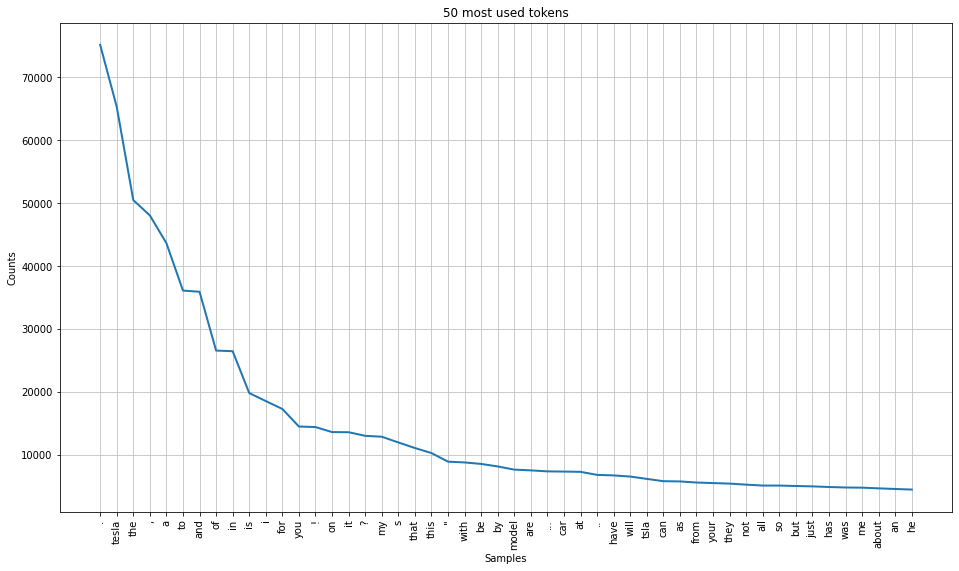

In [41]:
plt.figure(figsize=FIGURE_SIZE)
freq_dist.plot(50, title="50 most used tokens")

### Most used words after removing stop words and punctuations

In [42]:
# nltk.download('stopwords')

from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

# Add 'google' and 'search' in stop words
stop_words.add('google')
stop_words.add('search')
# Remove stopwords
freq_dist = nltk.FreqDist(dict((word, freq) for word, freq in freq_dist.items() if word not in stop_words and word.isalpha()))

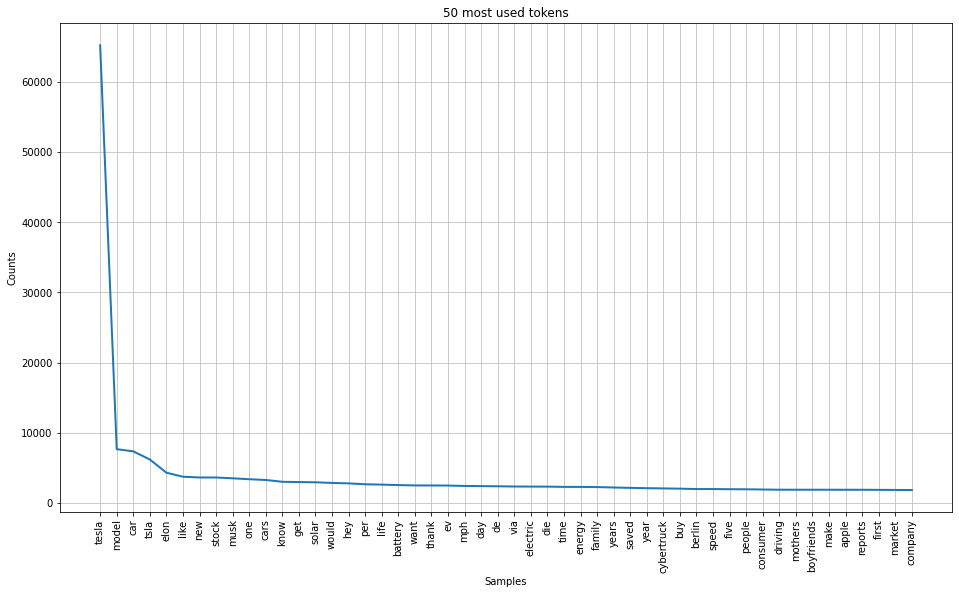

In [43]:
plt.figure(figsize=FIGURE_SIZE)
freq_dist.plot(50, title="50 most used tokens")

## Feature Creation

### 'is_retweet' from 'tweet_source' and 'tweet_id'

In [44]:
def is_retweet(x):
    return x[0] != x[1]

In [45]:
tweets['is_retweet'] = tweets[['tweet_source','tweet_id']].apply(lambda x: is_retweet(x), axis=1)

In [46]:
tweets[['tweet_source','tweet_id','is_retweet']].head()

,tweet_source,tweet_id,is_retweet
0,1229834880919441408,1229838598926749698,True
1,1229837650938429441,1229838607646707713,True
2,1229555919245250560,1229838608288428033,True
3,1229828231567675393,1229838618107293696,True
4,1229838619889680389,1229838619889680389,False


### 'hashtags' from 'text'

In [47]:
HASHTAG_PATTERN = re.compile(r'#\w*')
def get_hashtags(text):
    return ' '.join(HASHTAG_PATTERN.findall(text))

In [48]:
tweets['hashtags'] = tweets['text'].apply(lambda x: get_hashtags(x))

In [49]:
tweets[['text','hashtags']].head()

,text,hashtags
0,"Tesla entwickelte das Teil, das neben Fahrassi...",
1,Highlight: “We’re seeing Tesla up another 6% t...,
2,Tesla decidió descartar Cataluña para su nueva...,
3,Elon Musk calls Bill Gates ‘underwhelming’ htt...,
4,@ATNX143 @slicctor @CNN And accept the fact th...,


## Sentiment Analysis

In [50]:
def get_polarity(text):
    return TextBlob(text).polarity

def get_subjectivity(text):
    return TextBlob(text).subjectivity

In [51]:
tweets['polarity'] = tweets['clean_text'].apply(lambda x: get_polarity(x))
tweets['subjectivity'] = tweets['clean_text'].apply(lambda x: get_subjectivity(x))

In [52]:
tweets[['clean_text','polarity','subjectivity']].head()

,clean_text,polarity,subjectivity
0,"tesla entwickelte das teil, das neben fahrassi...",0.000000,0.000000
1,highlight we re seeing tesla up another today ...,0.000000,0.066667
2,tesla decidi descartar catalu a para su nueva ...,0.000000,0.000000
3,elon musk calls bill gates underwhelming,0.000000,0.000000
4,and accept the fact that competitors like pors...,0.033333,0.208333


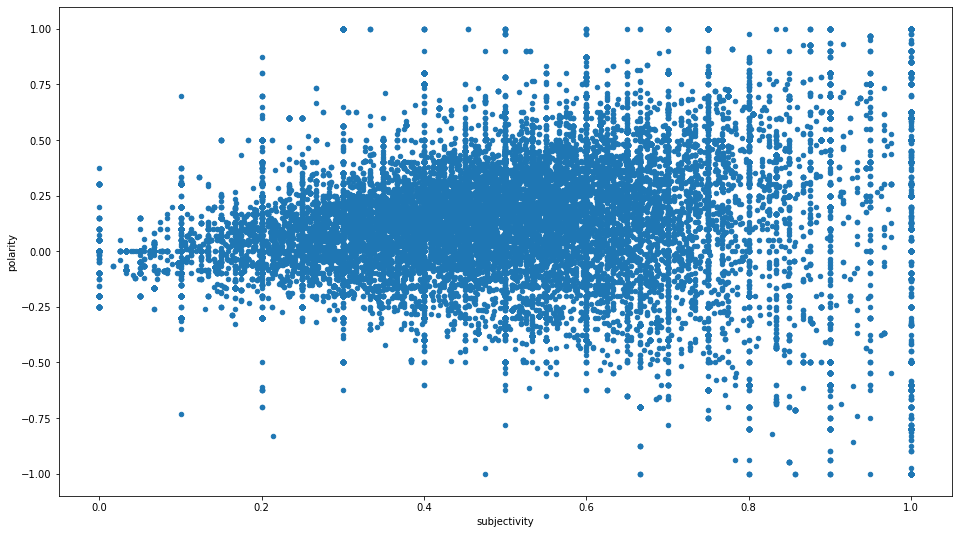

In [53]:
tweets[['polarity','subjectivity']].plot(kind='scatter', x='subjectivity', y='polarity',figsize=FIGURE_SIZE)

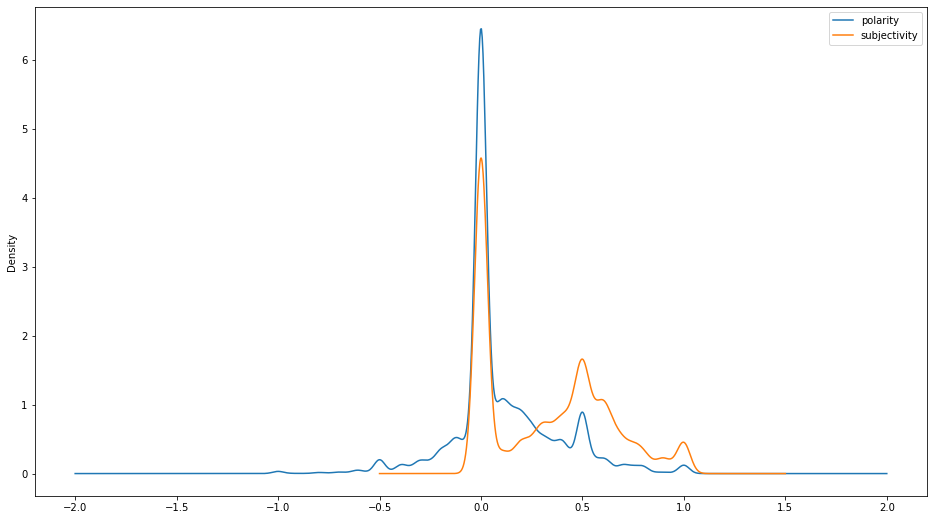

In [54]:
tweets[['polarity','subjectivity']].plot(figsize=FIGURE_SIZE, kind='density')

### Sentiment Over Time

In [55]:
def get_datetime(ts):
    return datetime.fromtimestamp(ts)

In [56]:
# Add datetime column
tweets['datetime'] = tweets['timestamp'].apply(lambda x: get_datetime(x))

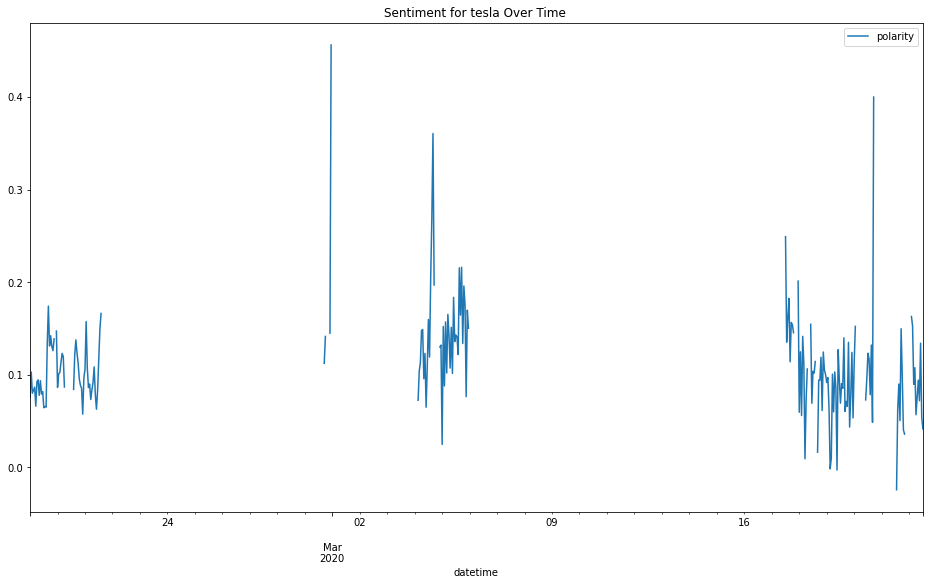

In [57]:
tweets[['datetime','polarity']].groupby(pd.Grouper(key='datetime', freq='H')).mean().plot(figsize=FIGURE_SIZE)
plt.title(f'Sentiment for {TARGET} Over Time ')
plt.show()

### Top Twitter Clients

In [58]:
client_popularity = tweets[['polarity','source_device']].groupby('source_device').size().sort_values(ascending=False)

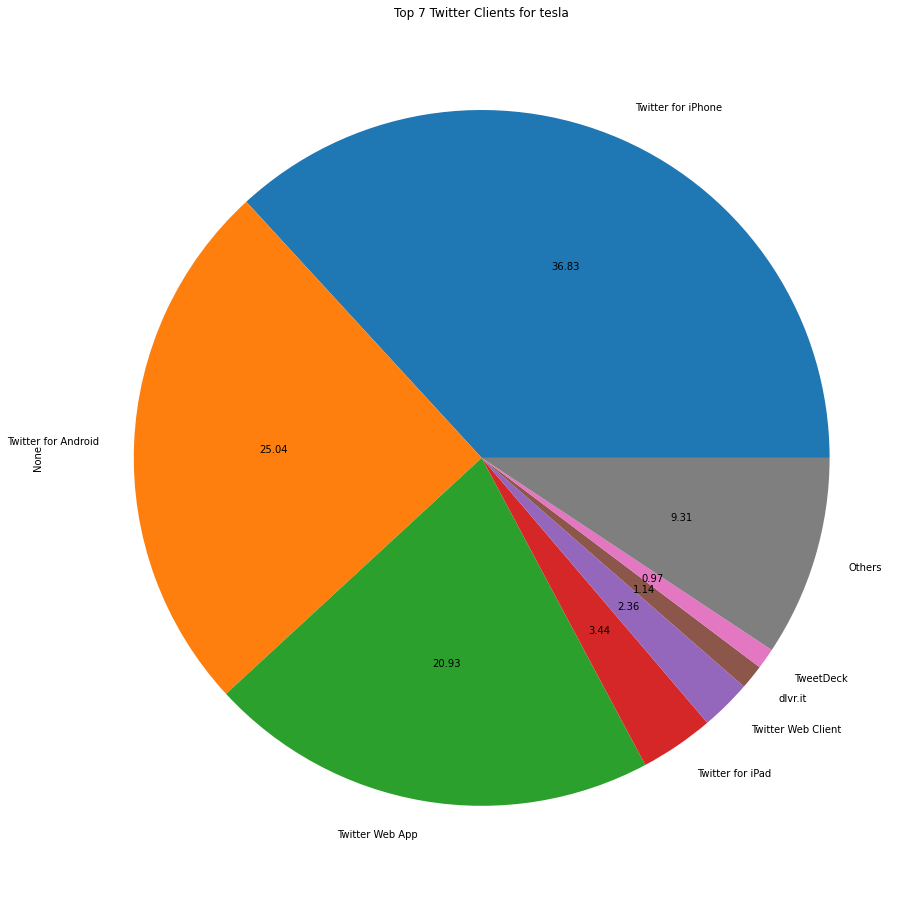

In [59]:
client_popularity[:7].append(pd.Series(client_popularity[7:].sum(), index=['Others'])).plot(kind='pie', autopct='%.2f', figsize=(16,16))
plt.title(f'Top 7 Twitter Clients for {TARGET}')
plt.show()

### Average Sentiment of people using particulat twitter clients

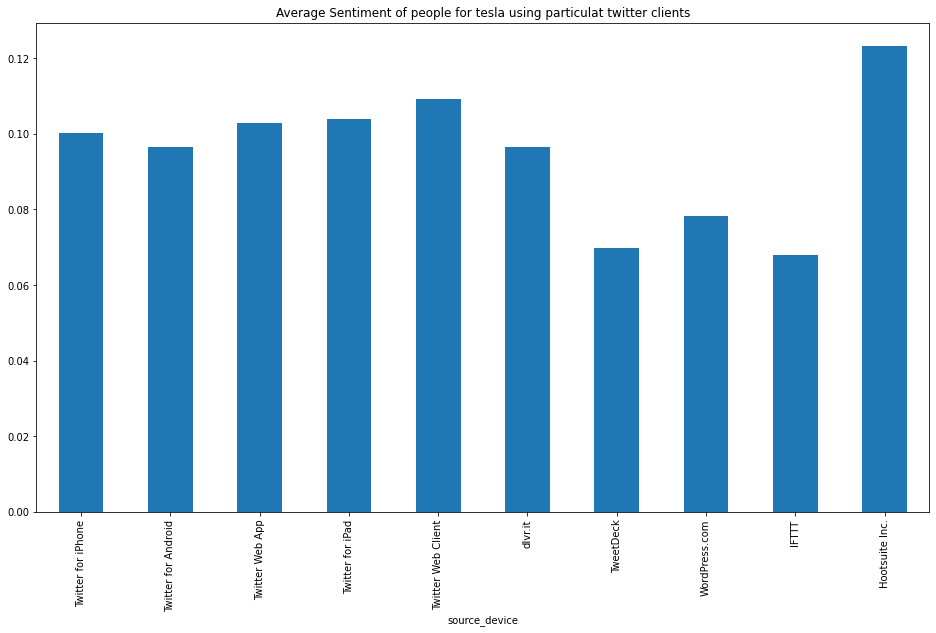

In [60]:
tweets[['datetime','polarity','source_device']].groupby('source_device').agg({
    'polarity': ['size', 'mean']
}).sort_values(('polarity','size'), ascending=False)[('polarity','mean')][:10].plot(kind='bar', figsize=FIGURE_SIZE)
plt.title(f'Average Sentiment of people for {TARGET} using particular twitter clients')
plt.show()